<a href="https://colab.research.google.com/github/Bileth/Grayscale-image-colorization/blob/master/CNN_colorize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D as Conv2D, MaxPooling2D
from keras.utils import np_utils
import keras
from keras.models import Sequential
from keras import backend as K
from keras import losses
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import mean_absolute_error

In [3]:
def read_images(path,num_images,xdim,ydim):
    images = []
    all_paths = os.listdir(path)
    mini_set = all_paths[:num_images]
    for i in mini_set:
        file = path+"/"+i
        image = cv2.imread(file)
        image = cv2.resize(image,(xdim,ydim))
        images.append(image)

    return images

#funkcija za pretvaranje rgb u  lab 
def rgb_to_lab(images):
    lab_images = []
    for i in images:
        lab_image= cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
        lab_images.append(lab_image)

    return lab_images

def lab_to_rgb(images):
    rgb_images = []
    for i in images:
        lab_image= cv2.cvtColor(i, cv2.COLOR_LAB2RGB)
        lab_images.append(lab_image)

#funkcija za izdvajanje l kanala i ab za trening 
def extract_channels(lab_images):
    l_channels = []
    a_channels = []
    b_channels = []
    for i in lab_images:
        l,a,b = cv2.split(i)
        l_channels.append(l)
        a_channels.append(a)
        b_channels.append(b)

    return np.array(l_channels), np.array(a_channels), np.array(b_channels)

#funkcija za stvaranje podataka za treniranje i testiranje
def create_train_data(l,a,b):
    train_data = []
    for i in l:
        train_data.append(np.array(i,dtype= 'float32'))
    train_labels_a = []
    train_labels_b = []
    for i in a:
        train_labels_a.append(np.array(i.flatten(),dtype='float32'))
    for i in b:
        train_labels_b.append(np.array(i.flatten(),dtype='float32'))
    train_labels = []
    for i,j in zip(train_labels_a,train_labels_b):
        train_labels.append(np.concatenate((i,j),axis = 0))
    
    return train_data, train_labels

In [4]:
!rm -rf clone && git clone https://github.com/Bileth/Grayscale-image-colorization clone && cp -a clone/. .

Cloning into 'clone'...
remote: Enumerating objects: 14342, done.
remote: Counting objects: 100% (14342/14342), done.
remote: Compressing objects: 100% (14334/14334), done.
remote: Total 14342 (delta 10), reused 14319 (delta 2), pack-reused 0
Receiving objects: 100% (14342/14342), 346.53 MiB | 22.84 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (22302/22302), done.


In [5]:
path = "train/images/color"  
num_images = 7000  
x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim)
lab_images = rgb_to_lab(images)
l,a,b = extract_channels(lab_images)
train_data, train_labels = create_train_data(l,a,b)

In [8]:
print(len(images))

7000


In [9]:
print(len(train_data))

7000


In [10]:
train_data = np.reshape(train_data,(num_images,x_dim,y_dim,1))
train_data.shape[3]
train_labels = np.reshape(train_labels,(num_images,128*128*2))

In [12]:
print(train_data.shape)

(7000, 128, 128, 1)


In [13]:
img_cols = 128
img_rows = 128
if K.image_data_format() == 'channels_first':
    train_data = train_data.reshape(train_data.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [14]:
model = Sequential()
model.add(Conv2D(64, (3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(train_labels.shape[1], activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 61, 61, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [16]:
model.compile(loss='mse',
              optimizer= opt)

In [17]:
batch_size = 64
epochs = 200
trainedmodel = model.fit(train_data, train_labels, epochs=epochs, validation_split = 0.1)

Epoch 1/200
197/197 [==============================] - 25s 71ms/step - loss: 16001.2695 - val_loss: 15812.2988
Epoch 2/200
197/197 [==============================] - 13s 64ms/step - loss: 11772.9521 - val_loss: 13973.6484
Epoch 3/200
197/197 [==============================] - 13s 65ms/step - loss: 2469.5728 - val_loss: 447.2829
Epoch 4/200
197/197 [==============================] - 13s 65ms/step - loss: 342.3705 - val_loss: 359.7649
Epoch 5/200
197/197 [==============================] - 13s 65ms/step - loss: 246.3934 - val_loss: 166.3129
Epoch 6/200
197/197 [==============================] - 13s 65ms/step - loss: 233.0981 - val_loss: 191.5218
Epoch 7/200
197/197 [==============================] - 13s 65ms/step - loss: 225.2186 - val_loss: 170.0842
Epoch 8/200
197/197 [==============================] - 13s 64ms/step - loss: 219.7666 - val_loss: 167.6593
Epoch 9/200
197/197 [==============================] - 13s 64ms/step - loss: 218.9992 - val_loss: 172.7591
Epoch 10/200
197/197 [======

In [18]:
model.save("CNN_colorize.h5")

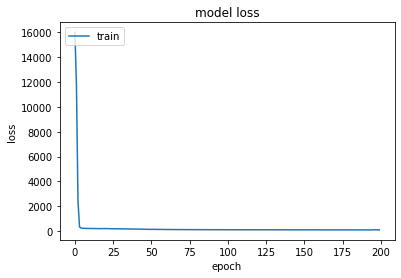

In [19]:
# summarize history for loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

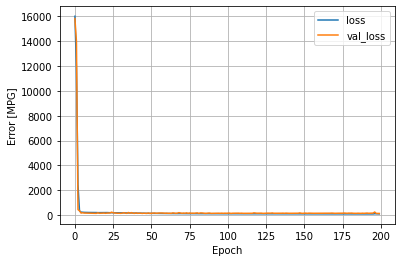

In [21]:
plot_loss(trainedmodel)

In [22]:
path = "test/images/gray"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
train_data, train_labels = create_train_data(l,a,b)

In [23]:
index = 16 #odabir slike
tr = np.reshape(train_data[index],(1,128,128,1)) 
p = model.predict(tr) 

In [24]:
x = list(p[0])
length = len(p[0])
x1 = x[:int(length/2)] #podjela predviđenog a i b kanala u jednake polovice kako bi ih dobili
x2 = x[int(length/2):]

x1 = np.array(np.reshape(x1,(x_dim,y_dim)),dtype = 'uint8')
x2 = np.array(np.reshape(x2,(x_dim,y_dim)),dtype = 'uint8')

t = np.array(np.reshape(tr,(x_dim,y_dim)),dtype = 'uint8')
pred = cv2.merge((t,x1,x2)) #spajanje L kanala sa a i b kanalima kako bi dobili obojanu sliku

True

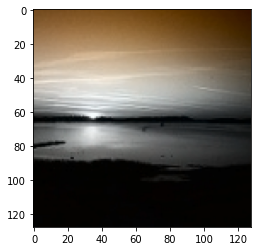

In [25]:
pred_n = cv2.cvtColor(pred, cv2.COLOR_LAB2RGB);
plt.imshow(pred_n)
cv2.imwrite('test/images/image18.png', pred_n)

In [26]:
path = "test/images/color"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
actual, actual_labels = create_train_data(l,a,b)

In [27]:
path = "test/images"
num_images = 19

x_dim = 128
y_dim = 128
images = read_images(path,num_images,x_dim,y_dim) 
lab_images = rgb_to_lab(images) 
l,a,b = extract_channels(lab_images)
predicted, predicted_labels = create_train_data(l,a,b)

error: ignored